## Linear Regression Vanilla Implementation from Scratch

* 20205318 Kim Jaeho

In [3]:
import numpy as np
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [4]:
data_dir = 'data/'
music_df = pd.read_csv(data_dir+'default_features_1059_tracks.csv')

In [5]:
X = np.array(music_df.iloc[:,:-2])

In [6]:
latitude = np.array(music_df.Latitude)
longitude = np.array(music_df.Longitude)

* Set random state to **split dataset into train, val, test**

In [7]:
random_state = 250

In [8]:
def split_data(X,latitude,longitude,random_state):
    X_train, X_test, latitude_train, latitude_test = train_test_split(X, latitude, test_size=0.2,random_state=random_state)
    _, _, longitude_train, longitude_test = train_test_split(X, longitude, test_size=0.2,random_state=random_state)
    X_train, X_val , latitude_train, latitude_val = train_test_split(X_train, latitude_train, test_size=0.2,random_state=random_state)
    longitude_train, longitude_val = train_test_split(longitude_train, test_size=0.2,random_state=random_state)
    
    return X_train, X_val, X_test, latitude_train, latitude_val ,latitude_test, longitude_train, longitude_val,longitude_test

In [9]:
X_train, X_val, X_test, latitude_train, latitude_val ,latitude_test, longitude_train, longitude_val,longitude_test=  split_data(X,latitude,longitude,random_state)

In [10]:
print(f'Train_X Shape:{X_train.shape}, Val_X:{X_val.shape}, Test_X Shape: {X_test.shape}')
print(f'latitude train Shape:{latitude_train.shape}, latitude val Shape:{latitude_val.shape}, latitude test Shape:{latitude_test.shape}')
print(f'longitude train Shape:{longitude_train.shape}, longitude val Shape:{longitude_val.shape}, longitude test Shape:{longitude_test.shape}')

Train_X Shape:(677, 68), Val_X:(170, 68), Test_X Shape: (212, 68)
latitude train Shape:(677,), latitude val Shape:(170,), latitude test Shape:(212,)
longitude train Shape:(677,), longitude val Shape:(170,), longitude test Shape:(212,)


### Implement Vanilla Regression Class

In [11]:
class LinearRegression:
    def __init__(self):
        pass
    def fit(self,train_X,train_y):
        assert isinstance(train_X,(np.ndarray)) == True
        assert isinstance(train_y,(np.ndarray)) == True
        self.train_X = train_X
        self.train_y = train_y
        self.N, self.D = train_X.shape
        self.estimate_coef()
    def estimate_coef(self):
        self.coef = np.matmul(np.matmul(inv(np.matmul(self.train_X.T,self.train_X)),self.train_X.T),self.train_y)
    def predict(self,test_X,test_y,print_score=True):
        predict_y = np.matmul(test_X,self.coef)
        if print_score:
            print('Implemented R2 score: ',self.r2_score(test_y,predict_y))
            print('ScikitLearn R2 score: ',r2_score(test_y,predict_y))
        return r2_score(test_y,predict_y)
    def r2_score(self,y_true,y_pred):
        y_bar = np.mean(y_true)
        SSR = np.sum((y_true-y_pred)**2)
        SST = np.sum((y_true-y_bar)**2)
        r2=  1-(SSR/SST)
        return r2
    def coef_values(self):
        coef_dict={}
        for idx,coef_val in enumerate(self.coef):
            coef_dict[str(idx+1)]= coef_val
        coef_dicts= dict(sorted(coef_dict.items(), key=lambda item: item[1]))
        plt.bar(range(len(coef_dicts)), list(coef_dicts.values()), align='center')
        plt.title('Coefficient Values Sorted')
        plt.show()

Implemented R2 score:  -2.374533006608664
ScikitLearn R2 score:  -2.374533006608664


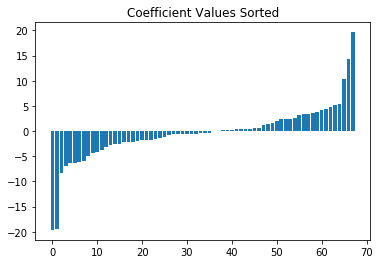

In [12]:
model = LinearRegression()
model.fit(X_train,latitude_train)
model.predict(X_test,latitude_test)
model.coef_values()

Implemented R2 score:  -0.728184538556683
ScikitLearn R2 score:  -0.728184538556683


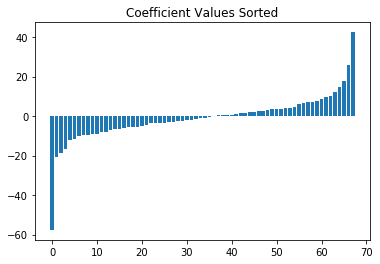

In [13]:
model = LinearRegression()
model.fit(X_train,longitude_train)
model.predict(X_test,longitude_test)
model.coef_values()

### Implement Ridge Regression Class(L2)

In [14]:
class RidgeLinearRegression(LinearRegression):
    def __init__(self,regularizer_coef=10):
        self.regularizer_coef = regularizer_coef
    def estimate_coef(self):
        self.coef = np.matmul(np.matmul(inv(np.matmul(self.train_X.T,self.train_X)+self.regularizer_coef*np.eye(self.D)),self.train_X.T),self.train_y)

Implemented R2 score:  -2.1954101730708655
ScikitLearn R2 score:  -2.1954101730708655


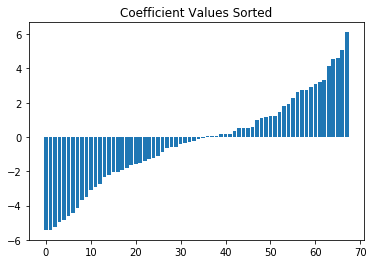

In [15]:
Ridge = RidgeLinearRegression()
Ridge.fit(X_train,latitude_train)
Ridge.predict(X_test,latitude_test)
Ridge.coef_values()

Implemented R2 score:  -0.5622973988208946
ScikitLearn R2 score:  -0.5622973988208946


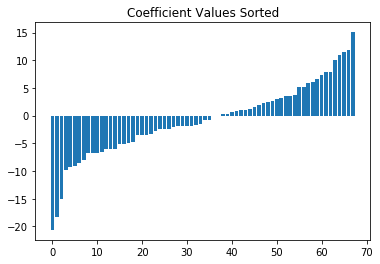

In [16]:
Ridge = RidgeLinearRegression()
Ridge.fit(X_train,longitude_train)
Ridge.predict(X_test,longitude_test)
Ridge.coef_values()

### Implement Lasso Regression Class(L1)

In [27]:
class LassoLinearRegression(LinearRegression):
    def __init__(self,regularizer_coef=50):
        self.regularizer_coef = regularizer_coef
    def estimate_coef(self,epoch=50):
        self.coef = np.zeros(self.D)
        update_threshold = 10
        #while update_threshold > 5:
        for e in range(epoch):
            for d in range(self.D):
                ro = self.calculate_ro_j(d)
                denominator = np.sum(self.train_X[:,d]**2,axis=0)
                if ro > self.regularizer_coef:
                    self.coef[d]= (-self.regularizer_coef+ro)/ denominator
                elif ro < -self.regularizer_coef:
                    self.coef[d]= (self.regularizer_coef+ro)/ denominator
                else:
                    self.coef[d]=0
    def calculate_ro_j(self,current_j):
        other_column_indices = [i for i in range(self.D) if i!=current_j]
        
        coefs_without_j = self.coef[other_column_indices]
        X_without_j = self.train_X[:,other_column_indices]
        ro = np.sum(np.multiply(self.train_y-np.sum(np.multiply(coefs_without_j,X_without_j),axis=1),self.train_X[:,current_j]),axis=0)
        return ro
    
    def count_zero_coefs(self):
        
    
        
        

Implemented R2 score:  -2.1375438308823327
ScikitLearn R2 score:  -2.1375438308823327


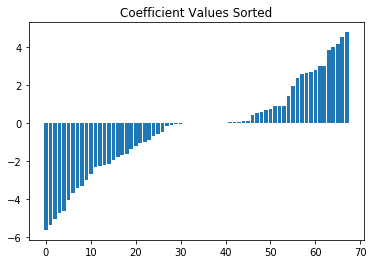

In [28]:
Lasso = LassoLinearRegression()
Lasso.fit(X_train,latitude_train)
Lasso.predict(X_test,latitude_test)
Lasso.coef_values()

Implemented R2 score:  -0.5583024759308051
ScikitLearn R2 score:  -0.5583024759308051


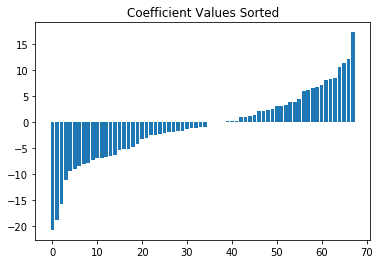

In [29]:
Lasso = LassoLinearRegression()
Lasso.fit(X_train,longitude_train)
Lasso.predict(X_test,longitude_test)
Lasso.coef_values()

### 2-A. 
* First, build a straightforward linear regression of latitude and longitude respectively against features. What is the R-squared of each model? Plot a graph evaluating each regression



In [30]:
def plot_r2(X,latitude,longitude):
    random_states = range(100)
    vanilla_latitude_regression=[]
    ridge_latitude_regression = []
    lasso_latitude_regression =[]
    
    vanilla_longitude_regression=[]
    ridge_longitude_regression = []
    lasso_longitude_regression =[]
    for i in random_states:
        if i%10==0:
            print('Random State ',i)
        X_train, X_val, X_test, latitude_train, latitude_val ,latitude_test, longitude_train, longitude_val,longitude_test= split_data(X,latitude,longitude,random_state=i)
        vanilla = LinearRegression()
        vanilla.fit(X_train,latitude_train)
        vanilla_latitude_regression.append(vanilla.predict(X_test,latitude_test,False))

        vanilla = LinearRegression()
        vanilla.fit(X_train,longitude_train)
        vanilla_longitude_regression.append(vanilla.predict(X_test,longitude_test,False))
        
        Ridge = RidgeLinearRegression()
        Ridge.fit(X_train,latitude_train)
        ridge_latitude_regression.append(Ridge.predict(X_test,latitude_test,False))

        Ridge = RidgeLinearRegression()
        Ridge.fit(X_train,longitude_train)
        ridge_longitude_regression.append(Ridge.predict(X_test,longitude_test,False))

        Lasso = LassoLinearRegression()
        Lasso.fit(X_train,latitude_train)
        lasso_latitude_regression.append(Lasso.predict(X_test,latitude_test,False))

        Lasso = LassoLinearRegression()
        Lasso.fit(X_train,longitude_train)
        lasso_longitude_regression.append(Lasso.predict(X_test,longitude_test,False))
    latitude_r2_dict ={'Vanilla_latitude':vanilla_latitude_regression,'Ridge_latitude':ridge_latitude_regression,'Lasso_latitude':lasso_latitude_regression,}

    longitude_r2_dict ={'Vanilla_longitude':vanilla_longitude_regression,'Ridge_longitude':ridge_longitude_regression,'Lasso_longitude':lasso_longitude_regression}
        
    return pd.DataFrame(latitude_r2_dict), pd.DataFrame(longitude_r2_dict)
        

In [31]:
latitude_df,longitude_df = plot_r2(X,latitude,longitude)

Random State  0
Random State  10
Random State  20
Random State  30
Random State  40
Random State  50
Random State  60
Random State  70
Random State  80
Random State  90


In [35]:
latitude_df.head()

,Vanilla_latitude,Ridge_latitude,Lasso_latitude
0,-2.246781,-2.087222,-2.059159
1,-1.496693,-1.462306,-1.440520
2,-2.042148,-1.924271,-1.883836
3,-1.623268,-1.551000,-1.534120
4,-2.567451,-2.403640,-2.410997


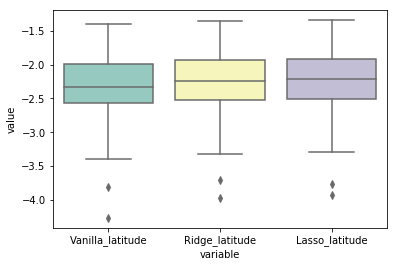

In [36]:
sns.boxplot(x = "variable", y = "value", palette = "Set3", data = pd.melt(latitude_df))

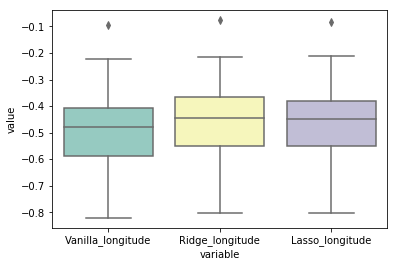

In [37]:
sns.boxplot(x = "variable", y = "value", palette = "Set3", data = pd.melt(longitude_df))

### 2-B. 
* A regression regularized by L2 (equivalently, a ridge regression). You should estimate the
regularization coefficient that produces the minimum error. Is the regularized regression better than the
unregularized regression?

In [68]:
def plot_by_lambda_Ridge(X_train,X_val, longitude_train,longitude_val,latitude_train,latitude_val,lambda_max=200):
    lambda_lists =[5*i for i in range(lambda_max)]
    r2_vals_longitude ={}
    r2_vals_latitude ={}
    for lambda_val in lambda_lists:
        Ridge = RidgeLinearRegression(regularizer_coef=lambda_val)
        Ridge.fit(X_train,longitude_train)
        r2_vals_longitude[lambda_val]=Ridge.predict(X_val,longitude_val,False)


        Ridge = RidgeLinearRegression(regularizer_coef=lambda_val)
        Ridge.fit(X_train,latitude_train)
        r2_vals_latitude[lambda_val]=Ridge.predict(X_val,latitude_val,False)
    lists_longitude = sorted(r2_vals_longitude.items())
    lists_latitude = sorted(r2_vals_latitude.items())
    x_long, y_long = zip(*lists_longitude)
    plt.title('Longitude')
    plt.xlabel('Lambda Value')
    plt.ylabel('R2')
    plt.plot(x_long, y_long)
    plt.show()
    plt.title('Latitude')
    plt.xlabel('Lambda Value')
    plt.ylabel('R2')
    x_lat, y_lat = zip(*lists_latitude)
    plt.plot(x_lat, y_lat)
    plt.show()

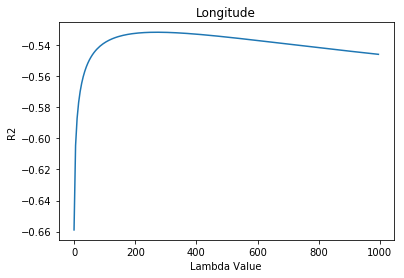

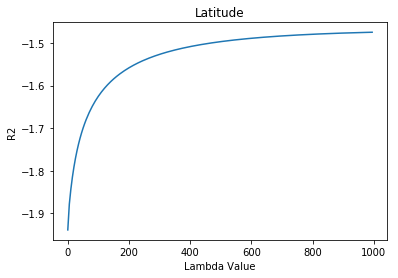

In [69]:
plot_by_lambda_Ridge(X_train,X_val, longitude_train,longitude_val,latitude_train,latitude_val)

Implemented R2 score:  -0.5327643687449803
ScikitLearn R2 score:  -0.5327643687449803


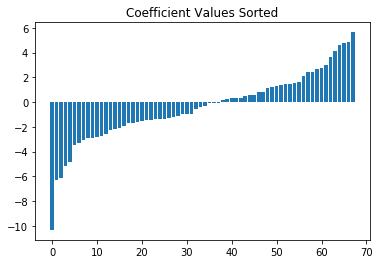

In [72]:
Ridge = RidgeLinearRegression(regularizer_coef=180)
Ridge.fit(X_train,longitude_train)
Ridge.predict(X_val,longitude_val)
Ridge.coef_values()

Implemented R2 score:  -0.5414580538007991
ScikitLearn R2 score:  -0.5414580538007991


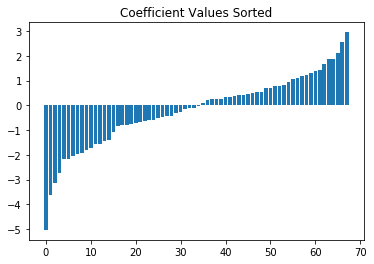

In [73]:
Ridge = RidgeLinearRegression(regularizer_coef=800)
Ridge.fit(X_train,longitude_train)
Ridge.predict(X_val,longitude_val)
Ridge.coef_values()

### 2-C. 
* A regression regularized by L1 (equivalently, a lasso regression). You should estimate the
regularization coefficient that produces the minimum error. How many variables are used by this
regression? Is the regularized regression better than the unregularized regression?

In [70]:
def plot_by_lambda_Lasso(X_train,X_val, longitude_train,longitude_val,latitude_train,latitude_val,lambda_max=200):
    lambda_lists =[5*i for i in range(lambda_max)]
    r2_vals_longitude ={}
    r2_vals_latitude ={}
    for lambda_val in lambda_lists:
        Lasso = LassoLinearRegression(regularizer_coef=lambda_val)
        Lasso.fit(X_train,longitude_train)
        r2_vals_longitude[lambda_val]=Lasso.predict(X_val,longitude_val,False)


        Lasso = LassoLinearRegression(regularizer_coef=lambda_val)
        Lasso.fit(X_train,latitude_train)
        r2_vals_latitude[lambda_val]=Lasso.predict(X_val,latitude_val,False)
    lists_longitude = sorted(r2_vals_longitude.items())
    lists_latitude = sorted(r2_vals_latitude.items())
    x_long, y_long = zip(*lists_longitude)
    plt.title('Longitude')
    plt.xlabel('Lambda Value')
    plt.ylabel('R2')
    plt.plot(x_long, y_long)
    plt.show()
    plt.title('Latitude')
    plt.xlabel('Lambda Value')
    plt.ylabel('R2')
    x_lat, y_lat = zip(*lists_latitude)
    plt.plot(x_lat, y_lat)
    plt.show()

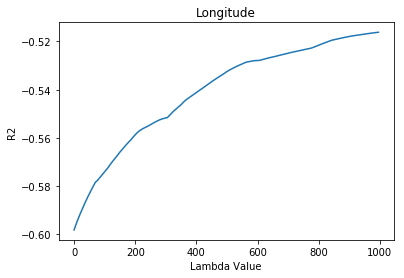

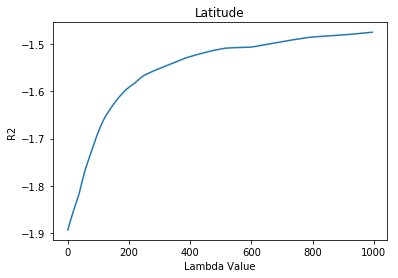

In [71]:
plot_by_lambda_Lasso(X_train,X_val, longitude_train,longitude_val,latitude_train,latitude_val,lambda_max=200)

Implemented R2 score:  -0.3994997486298921
ScikitLearn R2 score:  -0.3994997486298921


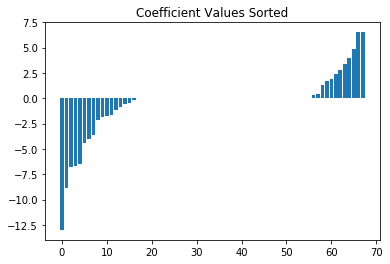

In [76]:
Lasso = LassoLinearRegression(regularizer_coef=800)
Lasso.fit(X_train,longitude_train)
Lasso.predict(X_test,longitude_test)
Lasso.coef_values()

Implemented R2 score:  -1.759199504893242
ScikitLearn R2 score:  -1.759199504893242


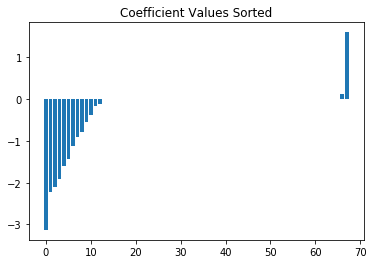

In [75]:
Lasso = LassoLinearRegression(regularizer_coef=800)
Lasso.fit(X_train,latitude_train)
Lasso.predict(X_test,latitude_test)
Lasso.coef_values()